## Suppose there's a pendulum suspended over three magnets, the forces acting on it are gravity, the magnetic atraction, and friction.

### Aproximations:
### -The string is very long, so let's consider the pendulum moving only in the x-y plane.
### -In this plane, i'll treat the problem as a damped oscillator.
### -The magnetic force is modeled by a potential proportional to the inverse of the distance squared.
### -The magnets are point-like.

### If M is the strenght of the magnetic force, xm ym the positions of the magnets and d the heigth of the plane x-y above the magnets, then
$$
{\Large V_m = \sum_{j=1}^3 \frac{M}{(x-x_{m,j})^2+(y-y_{m,j})^2+d^2}}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import numba
from numba import jit, prange
import pandas as pd

In [1]:
tmax = 100 #max time
dt = 0.01 #time resolution
n = int(tmax/dt) #number of iterations

M=1 #strength
d=0.25 #height
mu=0.15 #friction
#positions
xm=[1,-0.5,-0.5]
ym=[0,3**0.5/2,-3**0.5/2]
x=np.arange(-2,2,0.01)
y=np.arange(-2,2,0.01)
xv,yv=np.meshgrid(x,y)

zvv=[-M/((xv-xm[y])**2+(yv-ym[y])**2+d**2)**1.5 for y in range(len(xm))]
zv= np.sum(zvv,axis=0)


NameError: name 'np' is not defined

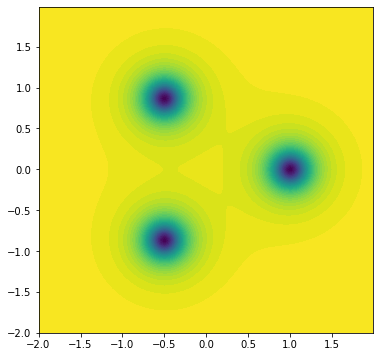

In [11]:
plt.figure(figsize=(6,6))
plt.contourf(xv,yv,zv,60)
plt.show()

In [14]:
@jit(nopython=True)
def potx(x,y):
    M=1.0
    d=0.25
    xm=[1,-0.5,-0.5]
    ym=[0,3**0.5/2,-3**0.5/2]
    Vxx=[0.0,0.0,0.0]
    VX=0.0
    for n in range(len(xm)):
        Vxx[n]=-(M*(x-xm[n])/((x-xm[n])**2+(y-ym[n])**2+d**2)**2.5)
    VX=Vxx[0]+Vxx[1]+Vxx[2]
    return VX

In [15]:
@jit(nopython=True)
def poty(x,y):
    M=1.0
    d=0.25
    xm=[1,-0.5,-0.5]
    ym=[0,3**0.5/2,-3**0.5/2]
    Vyy=[0.0,0.0,0.0]
    VY=0.0
    for n in range(len(xm)):
        Vyy[n]=-(M*(y-ym[n])/((x-xm[n])**2+(y-ym[n])**2+d**2)**2.5)
    VY=Vyy[0]+Vyy[1]+Vyy[2]
    return VY

We're solving the problem
$$\frac{dx}{dt} = v $$
$$\frac{dv}{dt} = -x -\mu v + F_{mag}(x)$$

In [16]:
@jit(nopython=True)
def model(z,t):
    Zs=[z[1],-z[0]-mu*z[1]+potx(z[0],z[2]),z[3],-z[2]-mu*z[3]+poty(z[0],z[2])]
    return Zs

In [17]:
def solveode(x0,y0):
    time = np.arange(0,15,.2)
 
    Z = odeint(model,[x0,0,y0,0],time) 
    return Z

In [20]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [21]:
%%time
Z=solveode(-1.5,-1.7)
print(find_nearest(ym,Z[len(Z)-1][2]))

2
CPU times: total: 31.2 ms
Wall time: 28.9 ms


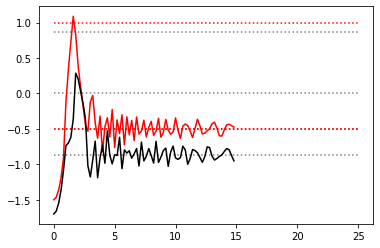

In [22]:
t=np.arange(0,15,.2)
plt.plot(t,Z.T[0],color='red')
plt.plot(t,Z.T[2],color='black')
plt.hlines(ym,0,25,linestyle=':',color='gray')
plt.hlines(xm,0,25,linestyle=':',color='red')
plt.show()

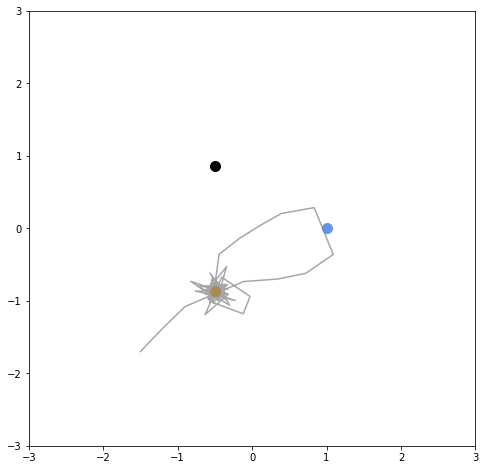

In [23]:
plt.figure(figsize=(8,8))
plt.plot(Z.T[0],Z.T[2],color='gray',alpha=0.7)
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.scatter(xm[0],ym[0],s=100,color='cornflowerblue')
plt.scatter(xm[1],ym[1],s=100,color='black')
plt.scatter(xm[2],ym[2],s=100,color='orange')
plt.show()

In [28]:
PREC=0.05
x=np.arange(-3.5,3.5,PREC)
y=np.arange(-3.5,3.5,PREC)
xv,yv=np.meshgrid(x,y)
co=xv*0

In [29]:
%%time
def draw():
    for i in range(len(x)):
        for j in range(len(y)):
            Z=solveode(x[i],y[j])
            co[j][i]=find_nearest(ym,Z[len(Z)-1][2])
draw()

CPU times: total: 8min 3s
Wall time: 8min 5s


In [30]:
df = pd.DataFrame(co)
df.to_csv('magnetic_pendulum.csv')

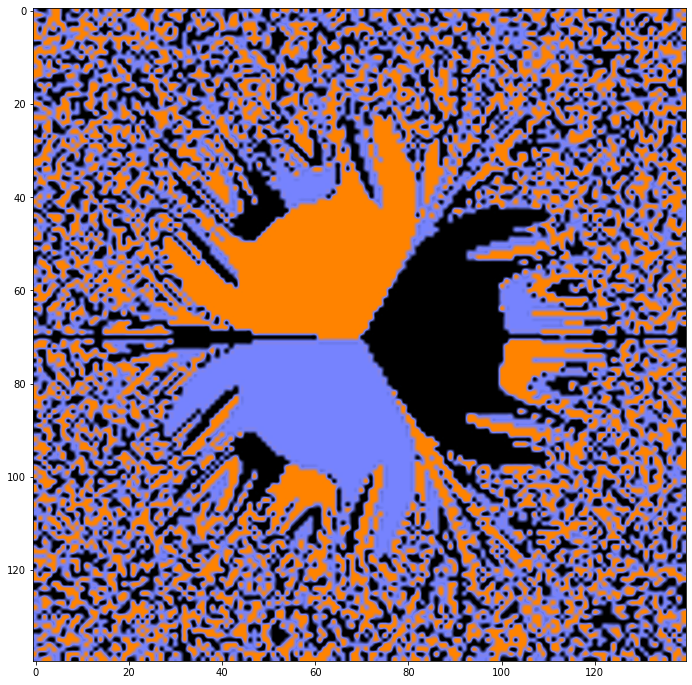

In [31]:
import matplotlib.colors as col
from matplotlib import cm
#estas lineas crean un color map interpolando 4 colores
colors = ["#000000","#7684FF","#FF8300"]
cmap1 = col.LinearSegmentedColormap.from_list("mycmap", colors)
plt.figure(figsize=(12,12))
plt.imshow(co,interpolation="catrom",cmap=cmap1)
plt.show()